In [1]:
import numpy as np
import numpy.ma as ma
import iris
import iris.plot as iplt
import iris.quickplot as qplt
import datetime
from iris.time import PartialDateTime
from iris.util import mask_cube_from_shapefile
import cartopy.io.shapereader as shpreader
from shapely.ops import unary_union
from shapely.geometry.polygon import Polygon
from shapely import MultiPolygon, Polygon
import matplotlib.pyplot as plt
import os
import torch
import sklearn
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable 
from torch.utils.data import Dataset

from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [2]:
filenames = ['C:/Users/Tilt/Downloads/Project/Data/data_2010.nc','C:/Users/Tilt/Downloads/Project/Data/data_2011.nc',
             'C:/Users/Tilt/Downloads/Project/Data/data_2012.nc','C:/Users/Tilt/Downloads/Project/Data/data_2013.nc',
             'C:/Users/Tilt/Downloads/Project/Data/data_2014.nc','C:/Users/Tilt/Downloads/Project/Data/data_2015.nc',
             'C:/Users/Tilt/Downloads/Project/Data/data_2016.nc','C:/Users/Tilt/Downloads/Project/Data/data_2017.nc',
             'C:/Users/Tilt/Downloads/Project/Data/data_2018.nc','C:/Users/Tilt/Downloads/Project/Data/data_2019.nc']
cubes = iris.load(filenames)
cubes = cubes.concatenate()
print(cubes)

0: observed_fraction_mask / (unknown)  (latitude: 720; longitude: 1440)
1: observed_fraction_mask / (unknown)  (latitude: 720; longitude: 1440)
2: observed_fraction_mask / (unknown)  (latitude: 720; longitude: 1440)
3: observed_fraction_mask / (unknown)  (latitude: 720; longitude: 1440)
4: observed_fraction_mask / (unknown)  (latitude: 720; longitude: 1440)
5: observed_fraction_mask / (unknown)  (latitude: 720; longitude: 1440)
6: observed_fraction_mask / (unknown)  (latitude: 720; longitude: 1440)
7: observed_fraction_mask / (unknown)  (latitude: 720; longitude: 1440)
8: observed_fraction_mask / (unknown)  (latitude: 720; longitude: 1440)
9: observed_fraction_mask / (unknown)  (latitude: 720; longitude: 1440)
10: population_density / (unknown)      (time: 120; latitude: 720; longitude: 1440)
11: 10 metre wind speed / (m s**-1)     (time: 120; latitude: 720; longitude: 1440)
12: 2 metre temperature / (K)           (time: 120; latitude: 720; longitude: 1440)
13: Convective available pot

In [3]:
ConstraintNames = [
    'burned_area',
    'population_density',
    '10 metre wind speed',
    '2 metre temperature',
    'Convective available potential energy',
    'Leaf area index, high vegetation',
    'Leaf area index, low vegetation',
    'Total precipitation',
    'Volumetric soil water layer 1',
    'observed_fraction_mask'
]

cubesList = { name: cubes.extract(iris.Constraint(name))[0] for name in ConstraintNames}
print(cubesList)

{'burned_area': <iris 'Cube' of burned_area / (m2) (time: 120; latitude: 720; longitude: 1440)>, 'population_density': <iris 'Cube' of population_density / (unknown) (time: 120; latitude: 720; longitude: 1440)>, '10 metre wind speed': <iris 'Cube' of 10 metre wind speed / (m s**-1) (time: 120; latitude: 720; longitude: 1440)>, '2 metre temperature': <iris 'Cube' of 2 metre temperature / (K) (time: 120; latitude: 720; longitude: 1440)>, 'Convective available potential energy': <iris 'Cube' of Convective available potential energy / (J kg**-1) (time: 120; latitude: 720; longitude: 1440)>, 'Leaf area index, high vegetation': <iris 'Cube' of Leaf area index, high vegetation / (m**2 m**-2) (time: 120; latitude: 720; longitude: 1440)>, 'Leaf area index, low vegetation': <iris 'Cube' of Leaf area index, low vegetation / (m**2 m**-2) (time: 120; latitude: 720; longitude: 1440)>, 'Total precipitation': <iris 'Cube' of Total precipitation / (m) (time: 120; latitude: 720; longitude: 1440)>, 'Volu

In [4]:
CountryName = "Madagascar"

country_shp_reader = shpreader.Reader(
    shpreader.natural_earth(
        resolution="110m", category="cultural", name="admin_0_countries"
    )
)
Country_shp = [
    country.geometry
    for country in country_shp_reader.records()
    if CountryName in country.attributes["NAME_LONG"]
][0]
ObsMaskCube = mask_cube_from_shapefile(cubesList["observed_fraction_mask"], Country_shp)
ObsMaskCube = iris.analysis.maths.log(ObsMaskCube)
ObsMaskCube = iris.analysis.maths.exp(ObsMaskCube)

b=0
a = ObsMaskCube.data
print("Verification - Count should Equal Sum")
print("Count =",ma.count(a))
print("Sum =",np.sum(a))
if(np.round(np.sum(a)) == ma.count(a)):
    b=b+1
print("Verification Mean should = 1")
print("Mean = ",np.mean(a))
if(np.round(np.mean(a)) == 1):
    b=b+1
print("We have",ma.count(a),"Datapoints Per Month")
if(b==2):
    print("All Verified - Continue")
else:
    print("Somethings gone wrong.")

BurnedCube = iris.analysis.maths.multiply(cubesList["burned_area"], ObsMaskCube)
PopnCube = iris.analysis.maths.multiply(cubesList["population_density"], ObsMaskCube)
WindCube = iris.analysis.maths.multiply(cubesList["10 metre wind speed"], ObsMaskCube)
TempCube = iris.analysis.maths.multiply(cubesList["2 metre temperature"], ObsMaskCube)
CAPECube = iris.analysis.maths.multiply(cubesList["Convective available potential energy"], ObsMaskCube)
HVegCube = iris.analysis.maths.multiply(cubesList["Leaf area index, high vegetation"], ObsMaskCube)
LVegCube = iris.analysis.maths.multiply(cubesList["Leaf area index, low vegetation"], ObsMaskCube)
PrecipCube = iris.analysis.maths.multiply(cubesList["Total precipitation"], ObsMaskCube)
SoilCube = iris.analysis.maths.multiply(cubesList["Volumetric soil water layer 1"], ObsMaskCube)

c:\Users\Tilt\miniconda3\Lib\site-packages\iris\_shapefiles.py:147: IrisDefaultingWarning: Cube has no coord_system; using default GeogCS lat/lon
  warnings.warn(


Verification - Count should Equal Sum
Count = 558
Sum = 558.0
Verification Mean should = 1
Mean =  1.0
We have 558 Datapoints Per Month
All Verified - Continue


c:\Users\Tilt\miniconda3\Lib\site-packages\dask\core.py:127: RuntimeWarning: divide by zero encountered in log
  return func(*(_execute_task(a, cache) for a in args))


(120, 720, 1440)
[0.0 0.0 0.0 ... 0.0 0.0 0.0]
66960
558


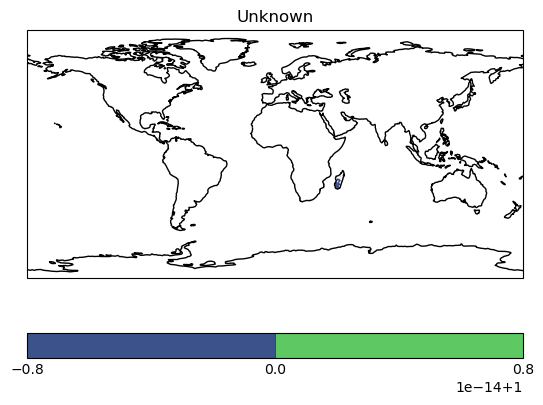

In [5]:
a = BurnedCube.data
print(np.shape(a))
aNoMask = a[~a.mask]
print(aNoMask)
print(len(aNoMask))

aMonth = BurnedCube[0].data
aNoMaskMonth = aMonth[~aMonth.mask]
print(len(aNoMaskMonth))
# 173 Datapoints Per for Portugal
Timesteps = round(len(aNoMask)/len(aNoMaskMonth))
Samples = len(aNoMaskMonth)

qplt.contourf(ObsMaskCube, 25)
plt.gca().coastlines()
plt.show()

In [6]:
def DeCube(InCube):
    InCube = InCube.data
    InCube = InCube[~InCube.mask]
    InCube = InCube.reshape(Timesteps, Samples)
    return InCube

In [7]:
#Verifying this doesnt break it
#a = BurnedCube.data
#a = a[~a.mask]
#print(len(a))

Burned = DeCube(BurnedCube)

Popn = DeCube(PopnCube)
Wind = DeCube(WindCube)
Temp = DeCube(TempCube)
CAPE = DeCube(CAPECube)
HVeg = DeCube(HVegCube)
LVeg = DeCube(LVegCube)
Precip = DeCube(PrecipCube)
Soil = DeCube(SoilCube)

Popn = np.log(Popn)

scaler = MinMaxScaler()
scaler.fit(Popn)
Popn = scaler.transform(Popn) 
scaler.fit(Wind)
Wind = scaler.transform(Wind) 
scaler.fit(Temp)
Temp = scaler.transform(Temp) 
scaler.fit(CAPE)
CAPE = scaler.transform(CAPE) 
scaler.fit(HVeg)
HVeg = scaler.transform(HVeg) 
scaler.fit(LVeg)
LVeg = scaler.transform(LVeg) 
scaler.fit(Precip)
Precip = scaler.transform(Precip) 
scaler.fit(Soil)
Soil = scaler.transform(Soil) 

In [8]:
X_full = np.dstack((Popn,Wind,Temp,CAPE,HVeg,LVeg,Precip,Soil))
print(X_full.shape)
X_full2D = X_full.reshape(-1, X_full.shape[-1])
print(X_full2D.shape)
X_full1D = Precip.reshape(X_full2D.shape[0],1)
print(X_full1D.shape)
y_full = Burned
y_full2D = y_full.reshape(X_full2D.shape[0],1)
y_full2DBinary = y_full2D
y_full2DBinary[y_full2D>0]=1
y_full2DBinary[y_full2D==0]=0
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_full2D, y_full2DBinary, test_size = 0.2, random_state = 42, shuffle=True)

print("Training Shape",X_train.shape,y_train.shape)
print("Testing Shape",X_test.shape,y_test.shape)

#from imblearn.over_sampling import RandomOverSampler
#ros = RandomOverSampler(random_state=42,sampling_strategy='minority')
#X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
#print(X_resampled.shape)
#print(y_resampled.shape)

(120, 558, 8)
(66960, 8)
(66960, 1)
Training Shape (53568, 8) (53568, 1)
Testing Shape (13392, 8) (13392, 1)


(75916, 8)
(75916,)


Text(0.5, 1.0, 'Validation Confusion Matrix for SVM Classifier - RBF')

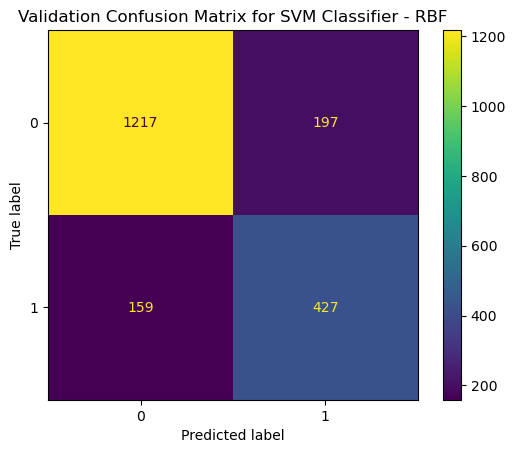

In [9]:
#Testing for the Best Hyperparams
from sklearn.svm import SVC
regressorRBF = SVC(kernel = 'rbf',degree=15,gamma=0.2,C=5)
regressorRBF.fit(X_train, y_train.ravel())
X_testsmall = X_test[:2000,]
y_testsml = y_test[:2000,]
y_predsml = regressorRBF.predict(X_testsmall)
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm = confusion_matrix(y_testsml, y_predsml)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Validation Confusion Matrix for SVM Classifier - RBF - Madagascar")

Text(0.5, 1.0, 'Validation Confusion Matrix for SVM Classifier - Poly')

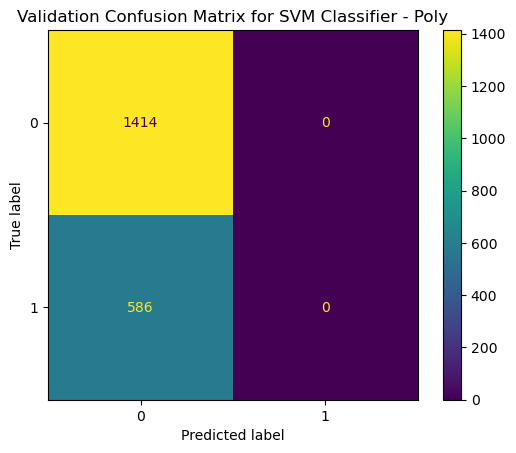

In [10]:
regressorPoly = SVC(kernel = 'poly',degree=15,gamma=0.2,C=5)
regressorPoly.fit(X_train, y_train.ravel())
X_testsmall = X_test[:2000,]
y_testsml = y_test[:2000,]
y_predsml = regressorPoly.predict(X_testsmall)
cm = confusion_matrix(y_testsml, y_predsml)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Validation Confusion Matrix for SVM Classifier - Poly")

Text(0.5, 1.0, 'Validation Confusion Matrix for SVM Classifier - Sigmoid')

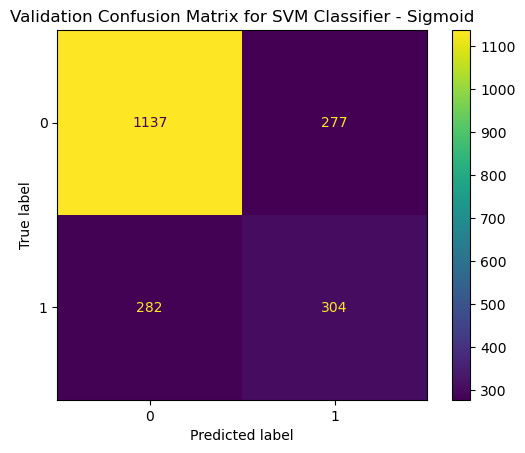

In [12]:
regressorSig = SVC(kernel = 'sigmoid',degree=15,gamma=0.2,C=5)
regressorSig.fit(X_train, y_train.ravel())
X_testsmall = X_test[:2000,]
y_testsml = y_test[:2000,]
y_predsml = regressorSig.predict(X_testsmall)
cm = confusion_matrix(y_testsml, y_predsml)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Validation Confusion Matrix for SVM Classifier - Sigmoid")

Text(0.5, 1.0, 'Validation Confusion Matrix for SVM Classifier - Linear')

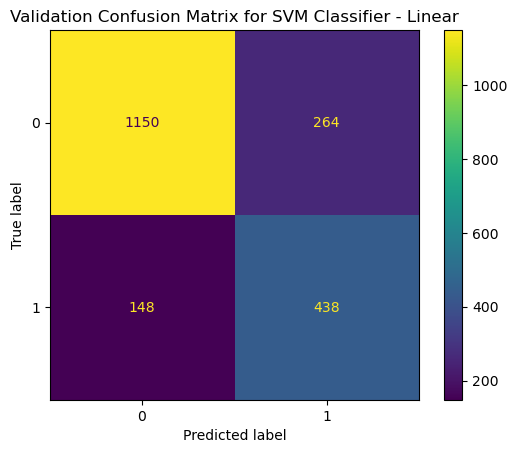

In [14]:
regressorLin = SVC(kernel = 'linear',degree=15,gamma=0.2,C=5)
regressorLin.fit(X_train, y_train.ravel())
X_testsmall = X_test[:2000,]
y_testsml = y_test[:2000,]
y_predsml = regressorLin.predict(X_testsmall)
cm = confusion_matrix(y_testsml, y_predsml)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Validation Confusion Matrix for SVM Classifier - Linear")

Text(0.5, 1.0, 'Confusion Matrix for SVM Classifier - Madagascar - Oversampled')

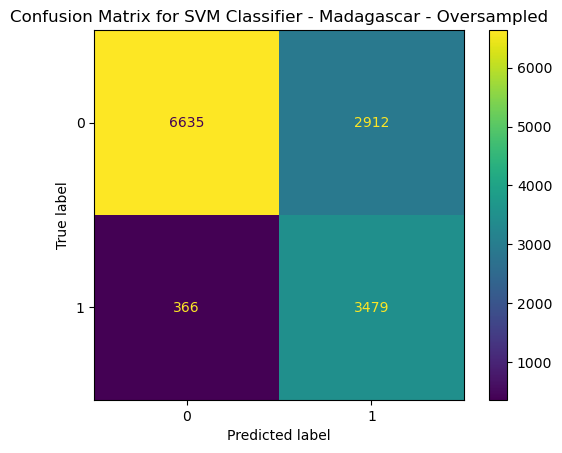

In [17]:
regressor = SVC(kernel = 'rbf',degree=15,gamma=0.5,C=0.5)
regressor.fit(X_train, y_train.ravel())
y_pred = regressor.predict(X_test)
#np.savetxt('y_predSVMOv.txt', y_pred, fmt='%d')
#np.savetxt('y_testSVMOv.txt', y_test, fmt='%d')
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Confusion Matrix for SVM Classifier - Madagascar")

In [11]:
#2020
filename2020 = 'C:/Users/Tilt/Downloads/Project/Data/data_2020.nc'
cube2020 = iris.load(filename2020)
cubesList2020 = { name: cube2020.extract(iris.Constraint(name))[0] for name in ConstraintNames}
print(cubesList2020)
BurnedCube2020 = iris.analysis.maths.multiply(cubesList2020["burned_area"], ObsMaskCube)
PopnCube2020 = iris.analysis.maths.multiply(cubesList2020["population_density"], ObsMaskCube)
WindCube2020 = iris.analysis.maths.multiply(cubesList2020["10 metre wind speed"], ObsMaskCube)
TempCube2020 = iris.analysis.maths.multiply(cubesList2020["2 metre temperature"], ObsMaskCube)
CAPECube2020 = iris.analysis.maths.multiply(cubesList2020["Convective available potential energy"], ObsMaskCube)
HVegCube2020 = iris.analysis.maths.multiply(cubesList2020["Leaf area index, high vegetation"], ObsMaskCube)
LVegCube2020 = iris.analysis.maths.multiply(cubesList2020["Leaf area index, low vegetation"], ObsMaskCube)
PrecipCube2020 = iris.analysis.maths.multiply(cubesList2020["Total precipitation"], ObsMaskCube)
SoilCube2020 = iris.analysis.maths.multiply(cubesList2020["Volumetric soil water layer 1"], ObsMaskCube)

{'burned_area': <iris 'Cube' of burned_area / (m2) (time: 12; latitude: 720; longitude: 1440)>, 'population_density': <iris 'Cube' of population_density / (unknown) (time: 12; latitude: 720; longitude: 1440)>, '10 metre wind speed': <iris 'Cube' of 10 metre wind speed / (m s**-1) (time: 12; latitude: 720; longitude: 1440)>, '2 metre temperature': <iris 'Cube' of 2 metre temperature / (K) (time: 12; latitude: 720; longitude: 1440)>, 'Convective available potential energy': <iris 'Cube' of Convective available potential energy / (J kg**-1) (time: 12; latitude: 720; longitude: 1440)>, 'Leaf area index, high vegetation': <iris 'Cube' of Leaf area index, high vegetation / (m**2 m**-2) (time: 12; latitude: 720; longitude: 1440)>, 'Leaf area index, low vegetation': <iris 'Cube' of Leaf area index, low vegetation / (m**2 m**-2) (time: 12; latitude: 720; longitude: 1440)>, 'Total precipitation': <iris 'Cube' of Total precipitation / (m) (time: 12; latitude: 720; longitude: 1440)>, 'Volumetric s

In [12]:
def DeCube2020(InCube):
    InCube = InCube.data
    InCube = InCube[~InCube.mask]
    InCube = InCube.reshape(12,Samples)
    return InCube

In [13]:
Burned2020 = DeCube2020(BurnedCube2020)
Popn2020 = DeCube2020(PopnCube2020)
Wind2020 = DeCube2020(WindCube2020)
Temp2020 = DeCube2020(TempCube2020)
CAPE2020 = DeCube2020(CAPECube2020)
HVeg2020 = DeCube2020(HVegCube2020)
LVeg2020 = DeCube2020(LVegCube2020)
Precip2020 = DeCube2020(PrecipCube2020)
Soil2020 = DeCube2020(SoilCube2020)
Popn2020 = np.log(Popn2020)
scaler = MinMaxScaler()
scaler.fit(Popn2020)
Popn2020 = scaler.transform(Popn2020) 
scaler.fit(Wind2020)
Wind2020 = scaler.transform(Wind2020) 
scaler.fit(Temp2020)
Temp2020 = scaler.transform(Temp2020) 
scaler.fit(CAPE2020)
CAPE2020 = scaler.transform(CAPE2020) 
scaler.fit(HVeg2020)
HVeg2020 = scaler.transform(HVeg2020) 
scaler.fit(LVeg2020)
LVeg2020 = scaler.transform(LVeg2020) 
scaler.fit(Precip2020)
Precip2020 = scaler.transform(Precip2020) 
scaler.fit(Soil2020)
Soil2020 = scaler.transform(Soil2020) 

X_full2020 = np.dstack((Popn2020,Wind2020,Temp2020,CAPE2020,HVeg2020,LVeg2020,Precip2020,Soil2020))
print(X_full2020.shape)
X_full2D2020 = X_full2020.reshape(-1, X_full2020.shape[-1])
print(X_full2D2020.shape)

y_full2020 = Burned2020
y_full2D2020 = y_full2020.reshape(X_full2D2020.shape[0],1)
y_full2DBinary2020 = y_full2D2020
y_full2DBinary2020[y_full2D2020>0]=1
y_full2DBinary2020[y_full2D2020==0]=0

(12, 558, 8)
(6696, 8)


Text(0.5, 1.0, 'Confusion Matrix for SVM Classifier - Madagascar - Oversapled - 2020 ')

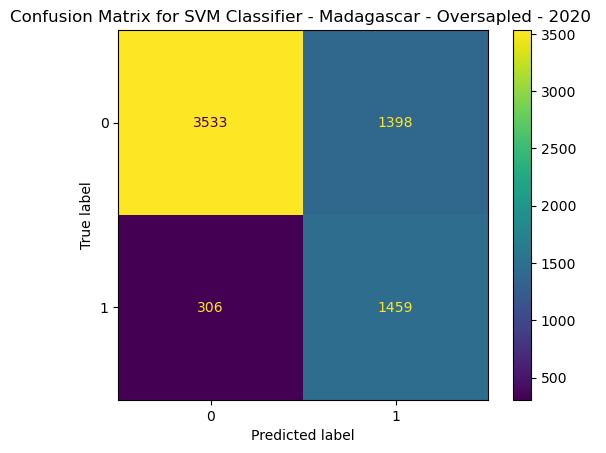

In [14]:
regressor = SVC(kernel = 'rbf',degree=20,gamma=1,C=5)
regressor.fit(X_train, y_train.ravel())

y_pred2020 = regressor.predict(X_full2D2020)
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
#np.savetxt('y_predKNNOv.txt', y_pred, fmt='%d')
#np.savetxt('y_testKNNOv.txt', y_test, fmt='%d')
cm = confusion_matrix(y_full2DBinary2020, y_pred2020)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Confusion Matrix for SVM Classifier - Madagascar - Oversapled - 2020 ")